In [24]:
import pandas as pd
import numpy as np
import r2pipe as r2
from tqdm import tqdm


## Dataset Preprocessing

In [25]:
CPU_ARCH = "x86_64"
SUPPORT_SHOTS = 5 # number of samples per class to use as support for training
QUERY_SHOTS = 5 # number of samples per class to use as query for training
SUPPORT_SHOTS_VA = 5 # number of samples per class to use as support for validation
QUERY_SHOTS_VA = 5 # number of samples per class to use as query for validation
N_GRAM_1 = 2
N_GRAM_2 = 4
N_WAYS = 10
NUM_EXAMPLES = 200
NUM_EXAMPLES_TEST = 30
BYTE_LENGTH = 2000
EPOCHS = 100
LEARNING_RATE = 0.001
LR_SCHEDULER_STEP = 20
LR_SCHEDULER_GAMMA = 0.5
ITERATIONS = 100 # number of episodes per epoch
CLASS_PER_ITER_TR = 5 # number of random classes per episode for training
CLASS_PER_ITER_VA = 5 # number of random classes per episode for validation
SEED = 7 # random seed
MODEL_NAME = "exp_cluster_after_1"
CUDA = False

In [26]:
# load dataset
DATASET_PATH = f"./dataset/malware_original_x86_64_byte_sequence{BYTE_LENGTH}_split.csv"
DATASET_FOLDER = "/home/mandy900619/data/Malware202403/"
CLUSTER_PATH = "./cluster_data/"
TSNE_PATH = "./pic/"
MODEL_PATH = "./models/"
LOG_PATH = "./logs/"
CPU_ARCH = "x86_64"  
EMBEDDING_PATH = "./dataset_embedding/" 


In [28]:
import pickle

print("Loading Data...")

with open(f"{EMBEDDING_PATH}{CPU_ARCH}_label_mapping.pickle", "rb") as f:
    label_mapping = pickle.load(f)
    f.close()

with open(f"{EMBEDDING_PATH}{CPU_ARCH}_tfidf_vec_train.pickle", "rb") as f:
    tfidf_matrix_train = pickle.load(f)
    f.close()

with open(f"{EMBEDDING_PATH}{CPU_ARCH}_tfidf_vec_test.pickle", "rb") as f:
    tfidf_matrix_test = pickle.load(f)
    f.close()

with open(f"{EMBEDDING_PATH}{CPU_ARCH}_y_train.pickle", "rb") as f:
    y_train = pickle.load(f)
    f.close()

with open(f"{EMBEDDING_PATH}{CPU_ARCH}_y_test.pickle", "rb") as f:
    y_test = pickle.load(f)
    f.close()


Loading Data...


In [29]:
print(f"Training set shape: {tfidf_matrix_train.shape}")
print(f"Testing set shape: {tfidf_matrix_test.shape}")
print(f"Label mapping: {label_mapping}")

Training set shape: (2000, 1000)
Testing set shape: (300, 1000)
Label mapping: {0: 'camelot', 1: 'gafgyt', 2: 'meterpreter', 3: 'mirai', 4: 'ngioweb', 5: 'rekoobe', 6: 'sliver', 7: 'sshdoor', 8: 'tsunami', 9: 'xmrig'}


## Data Relabel

In [37]:
CLUSTER_RESULT_PATH = "./cluster_result/"

for key in label_mapping:
    print(key, label_mapping[key])
    with open(f"{CLUSTER_RESULT_PATH}{label_mapping[key]}_cluster.txt", "r") as f:
        cluster = f.read().splitlines()
        f.close()
        cluster = [float(x) for x in cluster]
        cluster = np.array(cluster)
        unique, counts = np.unique(cluster, return_counts=True)
        print(unique, counts)



0 camelot
[  4. 140. 151.] [ 42 116  42]
1 gafgyt
[ 70. 131.] [121  79]
2 meterpreter
[  7.  77.  87. 122.] [ 11   2 186   1]
3 mirai
[  8. 156.] [ 51 149]
4 ngioweb
[ 18. 137.] [  5 195]
5 rekoobe
[ 14.  22.  52. 144.] [ 14 133  37  16]
6 sliver
[ 31.  80. 128. 152.] [  1   1   5 193]
7 sshdoor
[ 30.  34.  39. 112. 150.] [ 11   3 123  43  20]
8 tsunami
[108. 111. 199.] [153   4  43]
9 xmrig
[  1. 117.] [ 76 124]


### Experiment_Prototype Learning_1


In [132]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

In [133]:
if torch.cuda.is_available() and not CUDA:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

torch.cuda.cudnn_enabled = False
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [134]:
import torch.nn as nn

def linear_block(input_size, output_size, batch_norm=True, dropout_prob=0.5):
    layers = [nn.Linear(input_size, output_size)]
    if batch_norm:
        layers.append(nn.BatchNorm1d(output_size))
    layers.append(nn.ReLU())
    if dropout_prob > 0:
        layers.append(nn.Dropout(dropout_prob))
    return layers

class ByteSequenceEmbedding(nn.Module): # Can revise
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.5):
        super(ByteSequenceEmbedding, self).__init__()
        self.layers = nn.Sequential(
            *linear_block(input_size, hidden_size, batch_norm=True, dropout_prob=dropout_prob),
            *linear_block(hidden_size, hidden_size, batch_norm=True, dropout_prob=dropout_prob),
            *linear_block(hidden_size, output_size, batch_norm=False, dropout_prob=0)
        )


    def forward(self, x):
        return self.layers(x)


In [135]:
import torch 
import torch.nn.functional as F
from scipy.spatial import distance

class PrototypeNet(nn.Module):
    def __init__(self, embedding_model):
        super(PrototypeNet, self).__init__()
        self.embedding_model = embedding_model

    def forward(self, x):
        x = self.embedding_model(x)
        return x.view(x.size(0), -1)




In [136]:

trainData = tfidf_matrix_train.reshape(N_WAYS, NUM_EXAMPLES, -1)
yData = y_train.reshape(N_WAYS, NUM_EXAMPLES)
print(trainData.shape)
print(yData.shape)



(15, 20, 1000)
(15, 20)


In [137]:
import torch
from torch.utils.data import DataLoader, TensorDataset, Sampler

class ByteSequenceSampler(Sampler):
    def __init__(self, labels, n_shot, n_way, num_examples, classes_per_iter, iterations):
        self.labels = labels
        self.n_shot = n_shot
        self.n_way = n_way
        self.num_examples = num_examples
        self.classes_per_iter = classes_per_iter
        self.batch_size = n_shot * n_way
        self.iterations = iterations
        
        self.classes, self.counts = np.unique(self.labels, return_counts=True)
        self.classes = torch.LongTensor(self.classes)

        self.indexes = np.empty((self.n_way, self.num_examples), dtype=int) * np.nan
        # 15, 20
        self.indexes = torch.tensor(self.indexes)
        self.numel_per_class = torch.zeros_like(self.classes)

        for idx, label in enumerate(self.labels):
            label_idx = np.argwhere(self.classes == label).item()
            self.indexes[label_idx, np.where(np.isnan(self.indexes[label_idx]))[0][0]] = idx
            self.numel_per_class[label_idx] += 1
    def __iter__(self):
        '''
        yield a batch of indexes
        '''
        spc = self.n_shot
        cpi = self.classes_per_iter

        for it in range(self.iterations):
            batch_size = spc * cpi
            batch = torch.LongTensor(batch_size)
            c_idxs = torch.randperm(len(self.classes))[:cpi]
            for i, c in enumerate(self.classes[c_idxs]):
                s = slice(i * spc, (i + 1) * spc)
                # FIXME when torch.argwhere will exists
                label_idx = torch.arange(len(self.classes)).long()[self.classes == c].item()
                sample_idxs = torch.randperm(self.numel_per_class[label_idx])[:spc]
                batch[s] = self.indexes[label_idx][sample_idxs]
            batch = batch[torch.randperm(len(batch))]
            yield batch

    
    def __len__(self):
        '''
        returns the number of iterations (episodes) per epoch
        '''
        return self.iterations


In [138]:
import torch
from torch.nn import functional as F
from torch.nn.modules import Module

class PrototypicalLoss(Module):
    '''
    Loss class deriving from Module for the prototypical loss function defined below
    '''
    def __init__(self, n_support):
        super(PrototypicalLoss, self).__init__()
        self.n_support = n_support

    def forward(self, input, target):
        return prototypical_loss(input, target, self.n_support)   

def euclidean_dist(x, y):
    '''
    Compute euclidean distance between two tensors
    '''
    # x: N x D
    # y: M x D
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    if d != y.size(1):
        raise Exception

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)

def prototypical_loss(input, target, n_support):
    '''
    Inspired by https://github.com/jakesnell/prototypical-networks/blob/master/protonets/models/few_shot.py

    Compute the barycentres by averaging the features of n_support
    samples for each class in target, computes then the distances from each
    samples' features to each one of the barycentres, computes the
    log_probability for each n_query samples for each one of the current
    classes, of appartaining to a class c, loss and accuracy are then computed
    and returned
    Args:
    - input: the model output for a batch of samples
    - target: ground truth for the above batch of samples
    - n_support: number of samples to keep in account when computing
      barycentres, for each one of the current classes
    '''
    target_cpu = target.to('cpu')
    input_cpu = input.to('cpu')

    def supp_idxs(c):
        # FIXME when torch will support where as np
        return target_cpu.eq(c).nonzero()[:n_support].squeeze(1)

    # FIXME when torch.unique will be available on cuda too
    classes = torch.unique(target_cpu)
    n_classes = len(classes)
    # FIXME when torch will support where as np
    # assuming n_query, n_target constants
    n_query = target_cpu.eq(classes[0].item()).sum().item() - n_support

    support_idxs = list(map(supp_idxs, classes))

    prototypes = torch.stack([input_cpu[idx_list].mean(0) for idx_list in support_idxs])

    # FIXME when torch will support where as np
    query_idxs = torch.stack(list(map(lambda c: target_cpu.eq(c).nonzero()[n_support:], classes))).view(-1)

    query_samples = input.to('cpu')[query_idxs]
    dists = euclidean_dist(query_samples, prototypes)

    log_p_y = F.log_softmax(-dists, dim=1).view(n_classes, n_query, -1)

    target_inds = torch.arange(0, n_classes)
    target_inds = target_inds.view(n_classes, 1, 1)
    target_inds = target_inds.expand(n_classes, n_query, 1).long()

    loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
    _, y_hat = log_p_y.max(2)
    acc_val = y_hat.eq(target_inds.squeeze(2)).float().mean()
    
    return loss_val,  acc_val, prototypes, query_samples, target_inds

In [139]:
from sklearn.metrics import accuracy_score


def train(model, dataloader, support_shots, optim,lr_scheduler , exp_name="default", save_model=False, val_dataloader=None):
    
    if val_dataloader is None:
        best_state = None
    
    loss_min = 100
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    best_acc = 0

    for epoch in range(EPOCHS):
        print('=== Epoch: {} ==='.format(epoch))
        model.train()
        for i, (data, labels) in enumerate(dataloader):
            optim.zero_grad()
            data = data.squeeze(1)
            data = data.float()
            embeddings = model(data)
            loss, acc, _, _, _ = prototypical_loss(embeddings, target=labels, n_support=support_shots)
            loss.backward()
            optim.step()   
            train_loss.append(loss.item())
            train_acc.append(acc.item()) 
        avg_loss = np.mean(train_loss[-(ITERATIONS):])
        avg_acc = np.mean(train_acc[-(ITERATIONS):])
        print('Avg Train Loss: {}, Avg Train Acc: {}'.format(avg_loss, avg_acc))
        lr_scheduler.step()
        if val_dataloader is not None:
            model.eval()
            for i, (data, labels) in enumerate(val_dataloader):
                model_output = model(data)
                loss, acc, _, _, _ = prototypical_loss(model_output, target=labels,
                                    n_support=support_shots)
                val_loss.append(loss.item())
                val_acc.append(acc.item())
            avg_loss = np.mean(val_loss[-(ITERATIONS):])
            avg_acc = np.mean(val_acc[-(ITERATIONS):])
            postfix = ' (Best)' if avg_acc >= best_acc else ' (Best: {})'.format(
                best_acc)
            print('Avg Val Loss: {}, Avg Val Acc: {}{}'.format(
                avg_loss, avg_acc, postfix))
            
        if avg_acc >= best_acc:
            torch.save(model.state_dict(), f"./models/model_{exp_name}.pt")
            best_acc = avg_acc
            best_state = model.state_dict()

    torch.save(model.state_dict(), f"./models/model_{exp_name}_check_point.pt")

    return best_state, best_acc, train_loss, train_acc, val_loss, val_acc



In [140]:
# Train the model


data_tensor = torch.tensor(tfidf_matrix_train)
label_tensor = torch.tensor(y_train)

trainDataset = TensorDataset(data_tensor, label_tensor)

sampler = ByteSequenceSampler(y_train, SUPPORT_SHOTS + QUERY_SHOTS, N_WAYS, NUM_EXAMPLES, CLASS_PER_ITER_TR, ITERATIONS) # support + query

trainLoader = DataLoader(trainDataset, batch_sampler=sampler)

embedding_model = ByteSequenceEmbedding(data_tensor.shape[1], 64, 64)

model = PrototypeNet(embedding_model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=LR_SCHEDULER_STEP, gamma=LR_SCHEDULER_GAMMA)
train(model, trainLoader, support_shots = SUPPORT_SHOTS, optim = optimizer, exp_name=MODEL_NAME, save_model=True, lr_scheduler=lr_scheduler, val_dataloader=None)

=== Epoch: 0 ===
Avg Train Loss: 0.9326347035169601, Avg Train Acc: 0.6592000031471252
=== Epoch: 1 ===
Avg Train Loss: 0.5250620230287314, Avg Train Acc: 0.8096000015735626
=== Epoch: 2 ===
Avg Train Loss: 0.44689592622220514, Avg Train Acc: 0.842799996137619
=== Epoch: 3 ===
Avg Train Loss: 0.3295995154324919, Avg Train Acc: 0.8739999976754188
=== Epoch: 4 ===
Avg Train Loss: 0.2836284079402685, Avg Train Acc: 0.8967999947071076
=== Epoch: 5 ===
Avg Train Loss: 0.2569492285139859, Avg Train Acc: 0.9059999960660935
=== Epoch: 6 ===
Avg Train Loss: 0.1922250782325864, Avg Train Acc: 0.9235999941825866
=== Epoch: 7 ===
Avg Train Loss: 0.18874107998795808, Avg Train Acc: 0.9355999952554703
=== Epoch: 8 ===
Avg Train Loss: 0.1394526085536927, Avg Train Acc: 0.9515999972820282
=== Epoch: 9 ===
Avg Train Loss: 0.1382713915221393, Avg Train Acc: 0.9547999930381775
=== Epoch: 10 ===
Avg Train Loss: 0.11795991799794138, Avg Train Acc: 0.9579999941587448
=== Epoch: 11 ===
Avg Train Loss: 0.1181

(OrderedDict([('embedding_model.layers.0.weight',
               tensor([[-0.0262, -0.0416, -0.0212,  ..., -0.0787, -0.0616,  0.0597],
                       [ 0.0424,  0.0119, -0.0437,  ..., -0.0153, -0.0117, -0.0711],
                       [-0.0074,  0.0015,  0.0322,  ...,  0.0017, -0.0201,  0.0494],
                       ...,
                       [ 0.0396,  0.0277,  0.0554,  ..., -0.0305, -0.0964,  0.0643],
                       [ 0.0008, -0.0109, -0.0163,  ..., -0.0192,  0.0041, -0.0663],
                       [ 0.0313, -0.0153, -0.0159,  ...,  0.0744,  0.0157, -0.1544]])),
              ('embedding_model.layers.0.bias',
               tensor([ 0.0556,  0.0645,  0.0383,  0.0030, -0.0013,  0.0077, -0.0508, -0.0018,
                        0.0181, -0.0231,  0.0495,  0.0163,  0.0848, -0.0224,  0.0353,  0.0617,
                       -0.0004, -0.0196,  0.0333,  0.0479,  0.0161,  0.0194,  0.0461, -0.0596,
                        0.0049, -0.0083,  0.0835,  0.0220, -0.0458,  0.0404,

In [141]:

def test(test_dataloader, model, support_shots=SUPPORT_SHOTS):
    '''
    Test the model trained with the prototypical learning algorithm
    '''
    device = 'cuda:0' if torch.cuda.is_available() and CUDA else 'cpu'
    avg_acc = list()
    for epoch in range(10):
        test_iter = iter(test_dataloader)
        for batch in test_iter:
            x, y = batch
            x, y = x.to(device), y.to(device)
            x = x.squeeze(1)
            x = x.float()
            model_output = model(x)
            _, acc, _, _, _ = prototypical_loss(model_output, target=y,
                             n_support=support_shots)
            avg_acc.append(acc.item())
    avg_acc = np.mean(avg_acc)
    print('Test Acc: {}'.format(avg_acc))

    return avg_acc
def eval():
    '''
    Initialize everything and train
    '''
    if torch.cuda.is_available() and not CUDA:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")

    data_tensor = torch.tensor(tfidf_matrix_test)
    label_tensor = torch.tensor(y_test)

    trainDataset = TensorDataset(data_tensor, label_tensor)

    sampler = ByteSequenceSampler(y_test, SUPPORT_SHOTS + QUERY_SHOTS, N_WAYS, NUM_EXAMPLES_TEST, CLASS_PER_ITER_TR, ITERATIONS) # support + query

    testLoader = DataLoader(trainDataset, batch_sampler=sampler)
    embedding_model = ByteSequenceEmbedding(data_tensor.shape[1], 64, 64)       
    model = PrototypeNet(embedding_model)

    model.load_state_dict(torch.load(f"./models/model_{MODEL_NAME}.pt"))

    test(test_dataloader=testLoader,model=model)

In [142]:
# Test the model

data_tensor = torch.tensor(tfidf_matrix_test)
label_tensor = torch.tensor(y_test)
    
trainDataset = TensorDataset(data_tensor, label_tensor)

sampler = ByteSequenceSampler(y_test, SUPPORT_SHOTS + QUERY_SHOTS, N_WAYS, NUM_EXAMPLES_TEST, CLASS_PER_ITER_TR, ITERATIONS) # support + query

testLoader = DataLoader(trainDataset, batch_sampler=sampler)

model.load_state_dict(torch.load(f"./models/model_{MODEL_NAME}.pt"))
model.eval()
test(testLoader, model)

Test Acc: 0.9776799957752228


0.9776799957752228

In [143]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
from textwrap import wrap

def visualize_embeddings(prototypes, query_embeddings, n_way, n_query, query_labels):
    prototypes_np = prototypes.detach().numpy()
    # print(prototypes_np.shape)
    query_labels = query_labels.squeeze(2)
    query_labels = query_labels.reshape(-1)
    query_embeddings_ = query_embeddings[torch.argsort(query_labels)]
    query_embeddings_np = query_embeddings_.detach().numpy()
    # print(query_embeddings_np.shape)


    # Combine prototypes and query embeddings for t-SNE
    combined_embeddings = np.vstack((prototypes_np, query_embeddings_np))
    tsne = TSNE(n_components=2, random_state=SEED)
    embeddings_2d = tsne.fit_transform(combined_embeddings)
    # print(embeddings_2d.shape)
    # Separate the transformed embeddings
    prototypes_2d = embeddings_2d[:n_way]
    query_embeddings_2d = embeddings_2d[n_way:]
    # print(prototypes_2d.shape)
    # print(query_embeddings_2d.shape)
    cmap = plt.get_cmap("tab20", n_way)
    
    # Plotting
    plt.figure(figsize=(14, 8))
    for i in label_mapping.keys():
        plt.scatter(prototypes_2d[i, 0], prototypes_2d[i, 1], marker='X', s=200, color=cmap(i), edgecolors='black', linewidth=0.5, label="\n".join(wrap(f'Prototype {label_mapping[i]}', 20)))
        plt.scatter(query_embeddings_2d[i*n_query:(i+1)*n_query, 0], query_embeddings_2d[i*n_query:(i+1)*n_query, 1], color=cmap(i), label="\n".join(wrap(f'Query {label_mapping[i]}', 20)))
    
    plt.grid(True)
    plt.legend(ncol=2, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('t-SNE Visualization of Prototypes and Queries')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

In [144]:

embeddings = model(data_tensor.float())
_, _, prototypes, query_embeddings, target_inds = prototypical_loss(embeddings, target=label_tensor, n_support=SUPPORT_SHOTS)



torch.Size([15, 64])
torch.Size([375, 64])


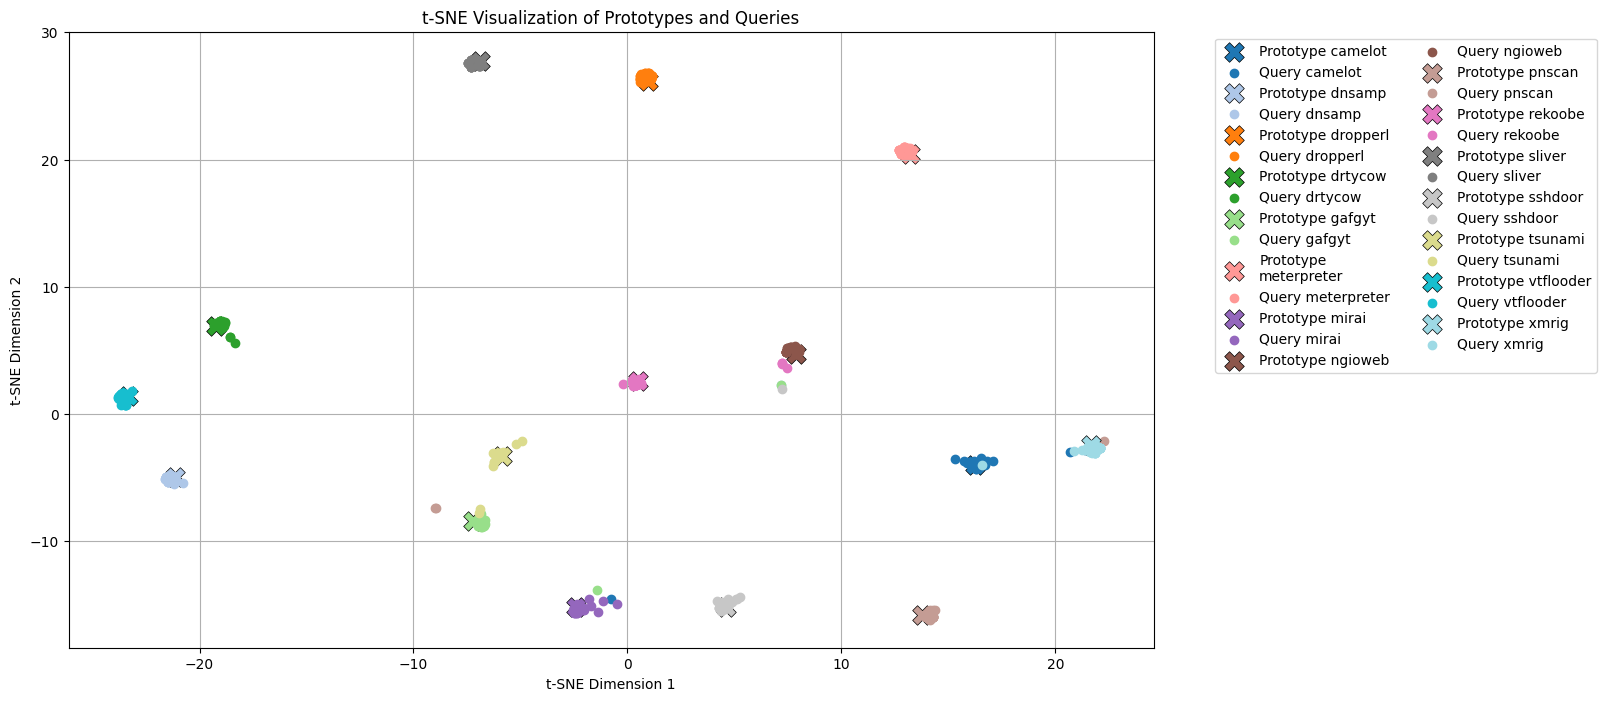

In [145]:
# print tsne
print(prototypes.shape)
print(query_embeddings.shape)

visualize_embeddings(prototypes, query_embeddings, N_WAYS, NUM_EXAMPLES_TEST - SUPPORT_SHOTS, query_labels=target_inds)

In [146]:
# print confusion matrix

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()



### Experiment_Machine Learning_1

In [147]:
print(f"Training dataset shape: {tfidf_matrix_train.shape}")
print(f"Labels shape: {y_train.shape}")
print(f"Test dataset shape: {tfidf_matrix_test.shape}")
print(f"Labels shape: {y_test.shape}")

Training dataset shape: (300, 1000)
Labels shape: (300,)
Test dataset shape: (450, 1000)
Labels shape: (450,)


In [148]:
# machine learning model
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Shuffle the dataset
tfidf_matrix_train, y_train = shuffle(tfidf_matrix_train, y_train, random_state=SEED)
tfidf_matrix_test, y_test = shuffle(tfidf_matrix_test, y_test, random_state=SEED)


svm_classifier = LinearSVC(C=0.2)
knn_classifier = KNeighborsClassifier(n_neighbors=3)
nb_classifier =  MultinomialNB()
mlp_classifier = MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=1000)

svm_classifier.fit(tfidf_matrix_train, y_train)
print("SVM Accuracy:", accuracy_score(y_test, svm_classifier.predict(tfidf_matrix_test)))   

knn_classifier.fit(tfidf_matrix_train, y_train)
print("KNN Accuracy:", accuracy_score(y_test, knn_classifier.predict(tfidf_matrix_test)))

nb_classifier.fit(tfidf_matrix_train, y_train)
print("NB Accuracy:", accuracy_score(y_test, nb_classifier.predict(tfidf_matrix_test)))

mlp_classifier.fit(tfidf_matrix_train, y_train)
print("MLP Accuracy:", accuracy_score(y_test, mlp_classifier.predict(tfidf_matrix_test)))

SVM Accuracy: 0.9133333333333333
KNN Accuracy: 0.9088888888888889
NB Accuracy: 0.8377777777777777
MLP Accuracy: 0.9577777777777777


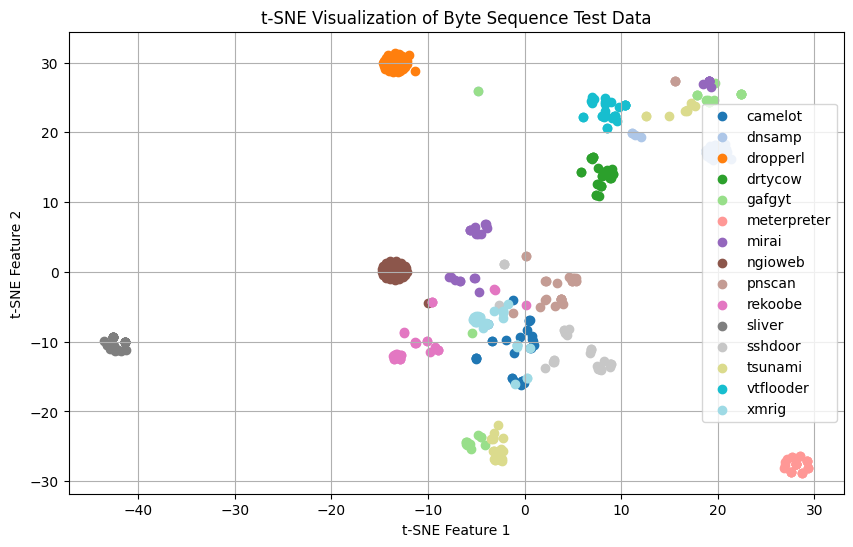

In [149]:
tsne = TSNE(n_components=2, random_state=SEED)
X_tsne = tsne.fit_transform(tfidf_matrix_test)
# 繪製t-SNE結果
plt.figure(figsize=(10, 6))
cmap = plt.get_cmap("tab20", N_WAYS)
for i in label_mapping.keys():
    plt.scatter(X_tsne[y_test == i, 0], X_tsne[y_test == i, 1], color=cmap(i), label=label_mapping[i])

plt.legend()
plt.title('t-SNE Visualization of Byte Sequence Test Data')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.grid(True)
plt.show()